In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from math import ceil
from scipy import stats
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import load_model
from nilmtk import DataSet
import keras_metrics as km
from keras import backend as K
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# 定义各变量
threshold=10
dimension=5
start='2012-11-9'
end='2013-5-15' #约160,0000个数据

train_start='2012-11-9'
train_end='2013-3-9'

val_start='2013-3-10'
val_end='2013-4-10'

test_start='2013-4-11'
test_end='2013-5-15'

In [3]:
#加载数据
data=DataSet('D:\\学习资料\\课程学习资料\\大四\\毕业设计\\NILM算法\\数据库\\ukdale.h5')
data.set_window(start="2012-11-9",end="2013-5-15")
elec=data.buildings[1].elec
fridge=elec['fridge']
washerdryer=elec['washer dryer']
dishwasher=elec['dish washer']
kettle=elec['kettle']
microwave=elec['microwave']

OSError: No such file as D:\学习资料\课程学习资料\大四\毕业设计\NILM算法\数据库\ukdale.h5

In [27]:
toaster=elec['toaster']
breadmaker=elec['breadmaker']
television=elec['television']

In [96]:
#对齐时间戳，创建包含各电器的功率和开关情况的数据
def creat_data(data,length):
    Data=pd.concat([data.power_series_all_data(), next(data.when_on())+0.],axis=1)[0:length]
    Data.columns=['active power','switch']
    return Data
fridge_data=creat_data(fridge,1600000)
washerdryer_data=creat_data(washerdryer,1600000)
dishwasher_data=creat_data(dishwasher,1600000)
kettle_data=creat_data(kettle,1600000)
microwave_data=creat_data(microwave,1600000)

toaster_data=creat_data(toaster,1600000)#有1600000帧数据
breadmaker_data=creat_data(breadmaker,1600000)#有1600000帧数据
television_data=creat_data(television,1600000) #有1600000帧数据

In [97]:
fridge_data.index=washerdryer_data.index=dishwasher_data.index=microwave_data.index=kettle_data.index=toaster_data.index=breadmaker_data.index=television_data.index
#对齐时间戳

In [65]:
# activations1=toaster.get_activations() #随机插入activations
# activations2=computer_monitor.get_activations()
# activations3=breadmaker.get_activations()
# activations4=hair_dryer.get_activations()
# activations5=television.get_activations()#可识别

In [98]:
#方案2 ：采用原始数据
target=dishwasher
target_data=dishwasher_data

In [99]:
#迭代器
def generator(data, label, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)##  随机取最小到最大的整数，宽度为batch_size
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))## 如果数据长度宽度超过最大值，以最大值为宽。
            i += len(rows)#如果不是随机的就累加i

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))## 默认是float类型 长度为108 lookback为20
        targets = np.zeros((len(rows),dimension))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices] ##20个数据
            targets[j] = label[rows[j] + delay]
        yield samples, targets ##for循环完了后再返回两个值。 sample有128批数据，每一批数据长20.

In [100]:
#方案2：采用原始数据
train_sum=(washerdryer_data+dishwasher_data+kettle_data+microwave_data+fridge_data+toaster_data+breadmaker_data+television_data)[train_start:train_end]['active power']
train_sum=train_sum.values.reshape(len(train_sum),1)
train_target=target_data[train_start:train_end]['active power'].values.reshape(len(train_sum),1)
train_label=np.where(train_target>threshold,1.,0.)

val_sum=(washerdryer_data+dishwasher_data+kettle_data+microwave_data+fridge_data+toaster_data+breadmaker_data+television_data)[val_start:val_end]['active power']
val_sum=val_sum.values.reshape(len(val_sum),1)
val_target=target_data[val_start:val_end]['active power'].values.reshape(len(val_sum),1)
val_label=target_data[val_start:val_end]['switch'].values.reshape(len(val_sum),1)

test_sum=(washerdryer_data+dishwasher_data+kettle_data+microwave_data+fridge_data+toaster_data+breadmaker_data+television_data)[test_start:test_end]['active power']
test_sum=test_sum.values.reshape(len(test_sum),1)
test_target=target_data[test_start:test_end]['active power'].values.reshape(len(test_sum),1)
test_label=target_data[test_start:test_end]['switch'].values.reshape(len(test_sum),1)

In [101]:
print("train:",len(train_sum))
print("validation:",len(val_sum))
print("test:",len(test_sum))

train: 1106497
validation: 390079
test: 103424


In [102]:
# 数据归一化
mean1=train_sum.mean(axis=0)
train_sum = train_sum -mean1
std1 = train_sum.std(axis=0)
train_sum /= std1  

mean2=val_sum.mean(axis=0)
val_sum=val_sum-mean2
std2=val_sum.std(axis=0)
val_sum /= std2

mean3=test_sum.mean(axis=0)
test_sum=test_sum-mean3
std3=test_sum.std(axis=0)
test_sum /=std3

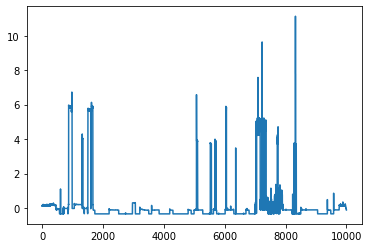

In [104]:
plt.plot(train_sum[0:10000])

In [105]:
#训练集、验证集、测试集中各电器的开启比例
print("train:",train_label.sum()/len(train_sum))
print("validation:",val_label.sum()/len(val_sum))
print("test:",test_label.sum()/len(test_sum))

train: 0.02533671577961802
validation: 0.02534358424831893
test: 0.02467512376237624


In [106]:
m=np.zeros(len(activations))
n=0
for x in activations:
    m[n]=len(x)
    n+=1
mean=ceil(m.mean())#获取activations长度的平均值
lookback = 256
step = 1
delay = 0
batch_size = 128
train_gen = generator(train_sum,
                      train_target,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(val_sum,
                    val_target,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(test_sum,
                    test_target,
                    lookback=lookback,
                    delay=delay, 
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)
train_steps = (len(train_sum)-lookback)// batch_size
val_steps = (len(val_sum) -lookback) // batch_size
test_steps = (len(test_sum)-lookback) // batch_size
print('mean=',mean)
print('lookback=',lookback)
print('train_steps=',train_steps)
print('val_steps=',val_steps)
print('test_steps=',test_steps)

mean= 1017
lookback= 256
train_steps= 8642
val_steps= 3045
test_steps= 806


In [76]:
#网络1 
model = Sequential()
model.add(layers.Conv1D(16, 4, activation='linear', input_shape=(None,train_sum.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.LSTM(32, dropout=0.1))
model.add(layers.Dense(1,activation='linear'))
model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])

In [208]:
#网络2
model = Sequential()
model.add(layers.Conv1D(16, 4, activation='linear', input_shape=(None,train_sum.shape[-1])))
model.add(layers.Bidirectional(layers.LSTM(128,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(256)))
model.add(layers.Dense(128,activation='tanh'))
model.add(layers.Dense(1,activation='linear'))
model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])

In [115]:
#网络3
model = Sequential()
model.add(layers.Conv1D(16, 4, activation='linear', input_shape=(None,train_sum.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(128,activation='tanh'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1,activation='relu'))
model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])

In [116]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 16)          80        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 21,073
Trainable params: 21,073
Non-trainable params: 0
__________________________________________________

In [17]:
## 保存训练过程中每一步的weights
filepath="D:\\pythonProject\\Exercise Codes\\新数据集训练\\电器功率分解\\22-4-7-dishwasher-cov+bi-lstm\\22-4-7-ModelWeights-epoch{epoch:.0f}-val_mae{val_mae:.4f}.hdf5"
checkpoint=ModelCheckpoint(filepath,mode='auto',monitor='val_mae')

In [ ]:
history=model.fit(train_gen,
                  steps_per_epoch=train_steps,
                  epochs=1,
#                   callbacks=[checkpoint],
                  validation_data=val_gen,
                  validation_steps=val_steps)

 193/8642 [..............................] - ETA: 15:46 - loss: 46708.0981 - mae: 25.3256

In [20]:
# 保存history
import pickle
with open('D:\\pythonProject\\Exercise Codes\\新数据集训练\\电器功率分解\\22-4-7-dishwasher-cov+bi-lstm\\history.txt', 'wb') as file_txt:
    pickle.dump(history.history, file_txt)
#保存model
model.save('D:\\pythonProject\\Exercise Codes\\新数据集训练\\电器功率分解\\22-4-7-dishwasher-cov+bi-lstm\\ 22-4-7-dishwasher-cov+bi-lstm.h5')

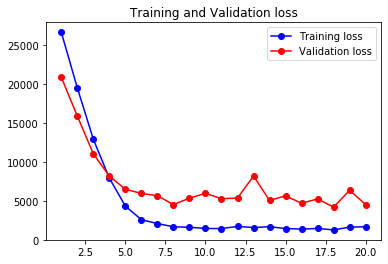

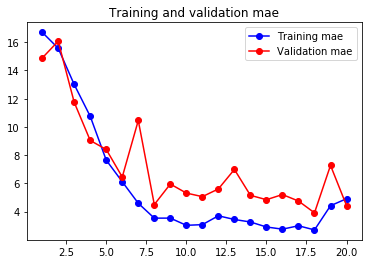

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, '-bo', label='Training loss')
plt.plot(epochs, val_loss, '-ro', label='Validation loss')
plt.title('Training and Validation loss')
xlabel=('Epoch')
ylabel=('loss')
plt.legend()
plt.show()

plt.clf()  # 清空图表

mae= history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs,mae,'-bo', label='Training mae')  # bo是蓝色圆点
plt.plot(epochs,val_mae,'-ro',label='Validation mae')  # b是蓝色实线
plt.title('Training and validation mae')
xlabel=('Epoch')
ylabel=('mae')
plt.legend()
plt.show()


In [ ]:
##对其时间轴
test_sum_data=test_sum[0+lookback:] 
test_target_data=test_target[0+lookback:] ##对齐时间轴
##数据复原
test_sum_data_real=test_sum_data*std1+mean1


plt.plot(test_sum_data_real[6200:6500,0],'-r',label='aggregate power') 
plt.plot(test_target_data[6200:6500,0],'g',label='ground truth power') 
plt.plot(test_predict[6200:6500,0],'-b',label='predict power')
plt.legend()